In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
import random
import warnings
warnings.filterwarnings('ignore')

In [4]:


# Read data
data = pd.read_csv('data.csv')

# Check data
print("Data Information:")
print(data.info())
print("\nSample Data:")
print(data.head())


Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB
None

Sample Data:
   work_year experience_level employment_type                 job_title  \
0       2023               SE              FT  Principal Data Scientist   
1       2023               MI 

In [5]:
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


In [6]:
data

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M
...,...,...,...,...,...,...,...,...,...,...,...
3750,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
3751,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
3752,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S
3753,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L


In [7]:

# Map experience levels to descriptive labels
data['experience_level'] = data['experience_level'].replace({
    'SE': 'Senior',
    'EN': 'Entry level',
    'EX': 'Executive level',
    'MI': 'Mid level',
})

# Map employment types to descriptive labels
data['employment_type'] = data['employment_type'].replace({
    'FL': 'Freelancer',
    'CT': 'Contractor',
    'FT': 'Full-time',
    'PT': 'Part-time'
})

# Map company sizes to descriptive labels
data['company_size'] = data['company_size'].replace({
    'S': 'Small',
    'M': 'Medium',
    'L': 'Large',
})

# Map remote ratios to descriptive labels
data['remote_ratio'] = data['remote_ratio'].astype(str).replace({
    '0': 'On-Site',
    '50': 'Hybrid',
    '100': 'Remote',
})

# Group similar job titles into broader categories
def assign_broader_category(job_title):
    data_engineering = [
        "Data Engineer", "Data Analyst", "Analytics Engineer", "BI Data Analyst",
        "Business Data Analyst", "BI Developer", "BI Analyst",
        "Business Intelligence Engineer", "BI Data Engineer", "Power BI Developer"
    ]
    data_science = [
        "Data Scientist", "Applied Scientist", "Research Scientist",
        "3D Computer Vision Researcher", "Deep Learning Researcher",
        "AI/Computer Vision Engineer"
    ]
    machine_learning = [
        "Machine Learning Engineer", "ML Engineer", "Lead Machine Learning Engineer",
        "Principal Machine Learning Engineer"
    ]
    data_architecture = [
        "Data Architect", "Big Data Architect", "Cloud Data Architect",
        "Principal Data Architect"
    ]
    management = [
        "Data Science Manager", "Director of Data Science", "Head of Data Science",
        "Data Scientist Lead", "Head of Machine Learning", "Manager Data Management",
        "Data Analytics Manager"
    ]
    
    if job_title in data_engineering:
        return "Data Engineering"
    elif job_title in data_science:
        return "Data Science"
    elif job_title in machine_learning:
        return "Machine Learning"
    elif job_title in data_architecture:
        return "Data Architecture"
    elif job_title in management:
        return "Management"
    else:
        return "Other"
        


# Apply the function to create the 'job_category' column
data['job_category'] = data['job_title'].apply(assign_broader_category)

In [8]:
numeric_columns = data.select_dtypes(include=['number']).columns
categorical_columns = data.select_dtypes(exclude=['number']).columns

print("\nNumeric Columns:")
print(numeric_columns)

print("\nCategorical Columns:")
print(categorical_columns)


Numeric Columns:
Index(['work_year', 'salary', 'salary_in_usd'], dtype='object')

Categorical Columns:
Index(['experience_level', 'employment_type', 'job_title', 'salary_currency',
       'employee_residence', 'remote_ratio', 'company_location',
       'company_size', 'job_category'],
      dtype='object')


In [9]:
count_Numeric = len(numeric_columns)
print("Number of Numeric Columns:", count_Numeric)

count_Categorical= len(categorical_columns)
print("Number of Categorical Columns:", count_Categorical)

Number of Numeric Columns: 3
Number of Categorical Columns: 9


In [10]:
missing_values = data.isnull().sum()
print(missing_values)
missing_values_count = missing_values[missing_values > 0].shape[0]

if missing_values_count > 0:
    print(f"There are {missing_values_count} columns with missing values.")
    print("\nColumns with missing values:")
    print(missing_values[missing_values > 0])
else:
    print("There are no missing values in the dataset.")


work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
job_category          0
dtype: int64
There are no missing values in the dataset.


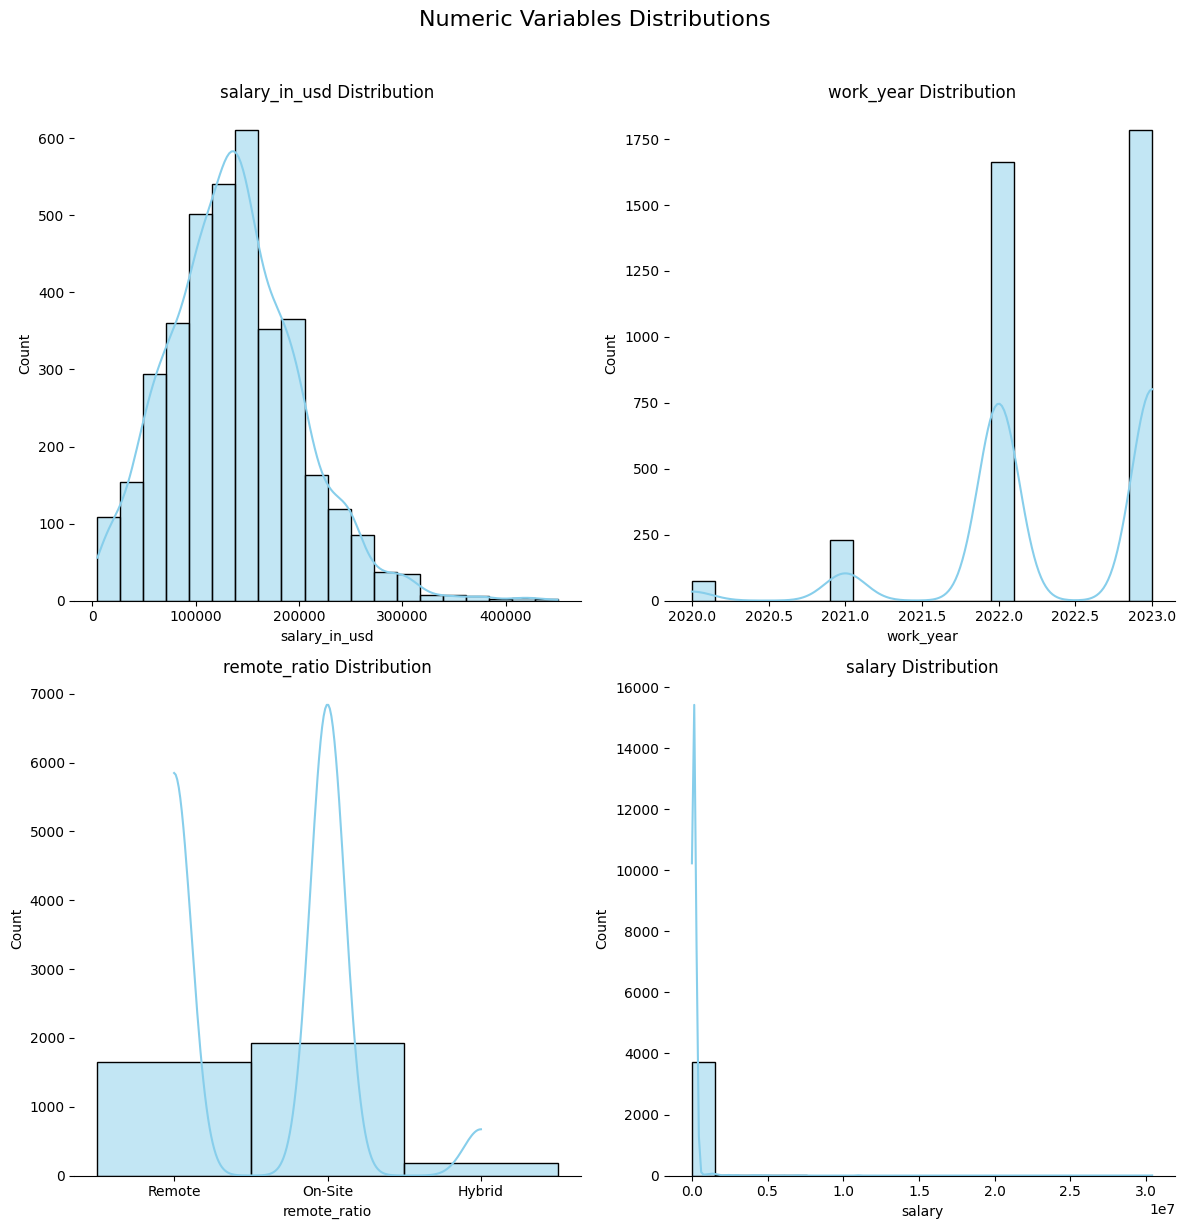

In [11]:

f, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=False)
sns.despine(left=True)

num_vars = ['salary_in_usd', 'work_year', 'remote_ratio', 'salary']

for i, col in enumerate(num_vars):
    sns.histplot(data[col], kde=True, color='skyblue', bins=20, ax=axes[i // 2, i % 2])  
    axes[i // 2, i % 2].set_title(f'{col} Distribution')  

f.suptitle("Numeric Variables Distributions", y=1.02, fontsize=16)

plt.tight_layout()
plt.show()


In [12]:
# data.drop(columns=['salary_in_usd'],inplace=True)

In [13]:
# Apply the function to create the 'job_category' column
data['job_category'] = data['job_title'].apply(assign_broader_category)

# Drop the original 'job_title' and 'salary_in_usd' columns
data = data.drop(columns=['job_title', 'salary_in_usd'])


In [14]:
data.dtypes

work_year              int64
experience_level      object
employment_type       object
salary                 int64
salary_currency       object
employee_residence    object
remote_ratio          object
company_location      object
company_size          object
job_category          object
dtype: object

In [19]:
!pip install plotly

  Using cached plotly-5.24.1-py3-none-any.whl.metadata (7.3 kB)
   ---------------------------------------- 0.0/19.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/19.1 MB ? eta -:--:--
   - -------------------------------------- 0.5/19.1 MB 1.5 MB/s eta 0:00:13
   -- ------------------------------------- 1.0/19.1 MB 2.2 MB/s eta 0:00:09
   -- ------------------------------------- 1.3/19.1 MB 1.9 MB/s eta 0:00:10
   --- ------------------------------------ 1.6/19.1 MB 1.8 MB/s eta 0:00:10
   ---- ----------------------------------- 2.1/19.1 MB 1.9 MB/s eta 0:00:09
   ---- ----------------------------------- 2.4/19.1 MB 2.0 MB/s eta 0:00:09
   ------ --------------------------------- 3.1/19.1 MB 2.0 MB/s eta 0:00:08
   ------- -------------------------------- 3.4/19.1 MB 2.1 MB/s eta 0:00:08
   -------- ------------------------------- 3.9/19.1 MB 2.0 MB/s eta 0:00:08
   -------- ------------------------------- 4.2/19.1 MB 1.9 MB/s eta 0:00:08
   --------- -------------

In [20]:
import plotly.express as px

In [21]:
type_grouped = data['employment_type'].value_counts()
e_type = ['Full-Time','Part-Time','Contract','Freelance']
fig = px.bar(x = e_type, y = type_grouped.values, 
       color = type_grouped.index, 
       color_discrete_sequence=px.colors.sequential.PuBuGn,
       template = 'plotly_dark',
       text = type_grouped.values, title = '2.1.3. Employment Type Distribution')
fig.update_layout(
    xaxis_title="Employment Type",
    yaxis_title="count",
    font = dict(size=17,family="Franklin Gothic"))
fig.update_traces(width=0.5)
fig.show()

In [72]:

# Identify categorical and numerical columns
categorical_columns = [
    'experience_level', 'employment_type', 'job_category',
    'salary_currency', 'employee_residence', 'company_location',
    'company_size', 'remote_ratio'
]

numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_columns.remove('salary')  # Remove target variable

# Define target and features
target = 'salary'
features = categorical_columns + numerical_columns
X = data[features]
y = data[target]

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ]
)

# Apply transformations
X_processed = preprocessor.fit_transform(X)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)



Linear Regression Performance:
MAE: 88028.46
MSE: 88328568171.15
RMSE: 297201.23
R2: 0.46

Decision Tree Performance:
MAE: 64841.28
MSE: 48937408036.05
RMSE: 221218.01
R2: 0.70

Random Forest Performance:
MAE: 60760.74
MSE: 33000350339.17
RMSE: 181659.99
R2: 0.80


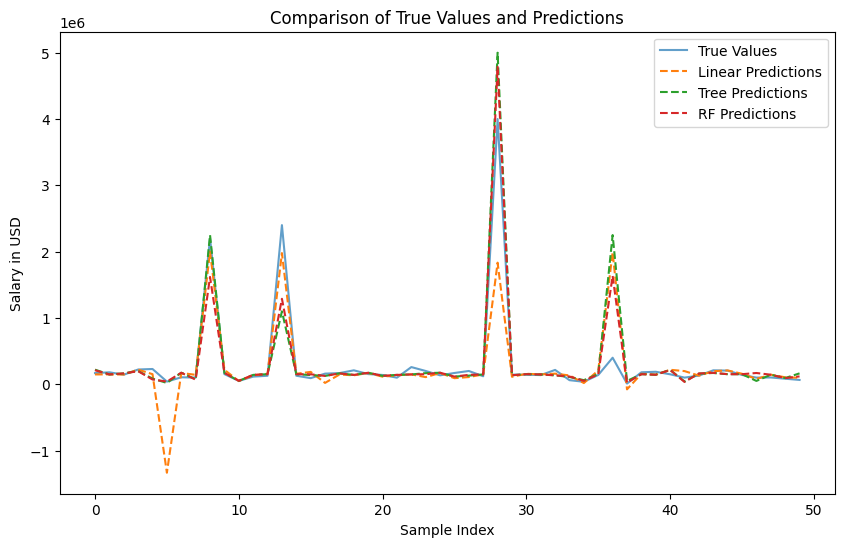

In [73]:

# 1. Train Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

# Evaluate Linear Regression
mse_linear = mean_squared_error(y_test, y_pred_linear)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)
r2_linear = r2_score(y_test, y_pred_linear)
print("\nLinear Regression Performance:")
print(f"MAE: {mae_linear:.2f}")
print(f"MSE: {mse_linear:.2f}")
print(f"RMSE: {rmse_linear:.2f}")
print(f"R2: {r2_linear:.2f}")

# 2. Train Decision Tree model
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)

# Evaluate Decision Tree
mse_tree = mean_squared_error(y_test, y_pred_tree)
mae_tree = mean_absolute_error(y_test, y_pred_tree)
rmse_tree = np.sqrt(mse_tree)
r2_tree = r2_score(y_test, y_pred_tree)
print("\nDecision Tree Performance:")
print(f"MAE: {mae_tree:.2f}")
print(f"MSE: {mse_tree:.2f}")
print(f"RMSE: {rmse_tree:.2f}")
print(f"R2: {r2_tree:.2f}")

# 3. Train Random Forest model
random_forest_model = RandomForestRegressor(random_state=42, n_estimators=100)
random_forest_model.fit(X_train, y_train)
y_pred_rf = random_forest_model.predict(X_test)

# Evaluate Random Forest
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print("\nRandom Forest Performance:")
print(f"MAE: {mae_rf:.2f}")
print(f"MSE: {mse_rf:.2f}")
print(f"RMSE: {rmse_rf:.2f}")
print(f"R2: {r2_rf:.2f}")

# Visual comparison of predictions
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[:50], label='True Values', alpha=0.7)
plt.plot(y_pred_linear[:50], label='Linear Predictions', linestyle='dashed')
plt.plot(y_pred_tree[:50], label='Tree Predictions', linestyle='dashed')
plt.plot(y_pred_rf[:50], label='RF Predictions', linestyle='dashed')
plt.legend()
plt.title("Comparison of True Values and Predictions")
plt.xlabel("Sample Index")
plt.ylabel("Salary in USD")
plt.show()


In [74]:
# Import necessary libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

# Train a RandomForest model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R2 Score: {r2}")

# Example: Predicting a new input data point
# Assume new_input_data is a dictionary or pandas DataFrame containing the necessary features.
new_input_data = {
    'work_year': 2023,  # Added missing feature
    'experience_level': 'Senior',
    'employment_type': 'Full-time',
    'job_category': 'Data Engineer',
    'salary_currency': 'USD',
    'employee_residence': 'USA',
    'company_location': 'USA',
    'company_size': 'Medium',
    'remote_ratio': 'On-Site'
}

# Convert the new input data into the same format as the training data
new_input_df = pd.DataFrame([new_input_data])

# Apply the same preprocessing transformations
new_input_processed = preprocessor.transform(new_input_df)

# Predict the salary for the new input
predicted_salary = model.predict(new_input_processed)

# Output the predicted salary
print(f"Predicted Salary for the input data: ${predicted_salary[0]:,.2f}")


Mean Squared Error: 33000350339.173622
Mean Absolute Error: 60760.73744665515
R2 Score: 0.7978558951299036
Predicted Salary for the input data: $152,156.47


In [75]:
!pip install gradio

  Using cached urllib3-2.2.3-py3-none-any.whl.metadata (6.5 kB)
INFO: pip is looking at multiple versions of requests to determine which version is compatible with other requirements. This could take a while.
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
Using cached urllib3-2.2.3-py3-none-any.whl (126 kB)
Using cached requests-2.32.3-py3-none-any.whl (64 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.8
    Uninstalling urllib3-1.26.8:
      Successfully uninstalled urllib3-1.26.8
  Attempting uninstall: requests
    Found existing installation: requests 2.27.1
    Uninstalling requests-2.27.1:
      Successfully uninstalled requests-2.27.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
connexion 3.0.5 requires starlette<0.33,>=0.27, but you have starlette 0.38.2 which is incompatible.
htmldate 1.8.1 requires charset-normalizer>=3.3.2; python_version >= "3.7", but you have charset-normalizer 2.0.10 which is incompatible.
pyppeteer 2.0.0 requires certifi>=2023, but you have certifi 2021.10.8 which is incompatible.
pyppeteer 2.0.0 requires urllib3<2.0.0,>=1.25.8, but you have urllib3 2.2.3 which is incompatible.
selenium 4.1.0 requires urllib3[secure]~=1.26, but you have urllib3 2.2.3 which is incompatible.
trafilatura 1.10.0 requires charset-normalizer>=3.2.0; python_version >= "3.7", but you have charset-normalizer 2.0.10 which is incompatible.


In [76]:
import gradio as gr
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Load data and preprocess as before
data = pd.read_csv('./salary_prediction_data/data.csv')

# Định nghĩa các bước tiền xử lý dữ liệu (giống như ở trước)
data['experience_level'] = data['experience_level'].replace({
    'SE': 'Senior',
    'EN': 'Entry level',
    'EX': 'Executive level',
    'MI': 'Mid level',
})
data['employment_type'] = data['employment_type'].replace({
    'FL': 'Freelancer',
    'CT': 'Contractor',
    'FT': 'Full-time',
    'PT': 'Part-time'
})
data['company_size'] = data['company_size'].replace({
    'S': 'Small',
    'M': 'Medium',
    'L': 'Large',
})
data['remote_ratio'] = data['remote_ratio'].astype(str).replace({
    '0': 'On-Site',
    '50': 'Hybrid',
    '100': 'Remote',
})

# Lọc ra dữ liệu cần thiết
categorical_columns = ['experience_level', 'employment_type', 'company_size', 'remote_ratio']
numerical_columns = ['years_of_experience', 'education_level']  # Example numerical columns

# Target variable
target = 'salary'
features = categorical_columns + numerical_columns
X = data[features]
y = data[target]

# Tiền xử lý dữ liệu
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ]
)

X_processed = preprocessor.fit_transform(X)

# Chia tập dữ liệu train-test
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Huấn luyện mô hình
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Hàm dự đoán mức lương
def predict_salary(experience_level, employment_type, company_size, remote_ratio, years_of_experience, education_level):
    # Tạo dataframe cho đầu vào mới
    input_data = {
        'experience_level': experience_level,
        'employment_type': employment_type,
        'company_size': company_size,
        'remote_ratio': remote_ratio,
        'years_of_experience': years_of_experience,
        'education_level': education_level
    }
    
    input_df = pd.DataFrame([input_data])
    
    # Tiền xử lý dữ liệu đầu vào
    input_processed = preprocessor.transform(input_df)
    
    # Dự đoán mức lương
    predicted_salary = model.predict(input_processed)
    
    return f"${predicted_salary[0]:,.2f}"

# Xây dựng giao diện Gradio
interface = gr.Interface(
    fn=predict_salary,  # Hàm sẽ được gọi khi người dùng nhập dữ liệu
    inputs=[
        gr.Dropdown(['Entry level', 'Mid level', 'Senior', 'Executive level'], label="Experience Level"),
        gr.Dropdown(['Freelancer', 'Contractor', 'Full-time', 'Part-time'], label="Employment Type"),
        gr.Dropdown(['Small', 'Medium', 'Large'], label="Company Size"),
        gr.Dropdown(['On-Site', 'Hybrid', 'Remote'], label="Remote Ratio"),
        gr.Slider(0, 50, step=1, label="Years of Experience"),  # Giả sử đây là tuổi nghề
        gr.Dropdown(['Bachelors', 'Masters', 'PhD'], label="Education Level"),
    ],
    outputs="text",  # Output là mức lương dự đoán
    title="Salary Prediction",  # Tiêu đề giao diện
    description="Enter the details to predict salary based on experience, employment type, and other factors."
)

# Chạy ứng dụng Gradio
interface.launch()


: 